<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Conjugacy and the Beta-Binomial Model

_Authors: Kiefer Katovich (SF)_

---

### Learning Objectives
- Describe the concept of "conjugacy" and "conjugate priors" in Bayesian statistics
- Set up an example of the Beta-Binomial model using a subscription probability example
- Calculate the Maximum Likelihood Estimate
- Describe when and why the MLE point estimate is insufficient
- Use the Beta-Binomial model to build our example in a Bayesian framework
- (Optional) Learn about the Beta function, Gamma function, and where they fit in the Beta distribution calculation
- (Optional) Mathematically derive the conjugacy relationship between the prior and posterior of the Beta-Binomial model


### Lesson Guide
- [Introduction](#intro)
- [Review: the Binomial distribution probability mass function](#pmf)
- [Modeling the parameter $p$ given counts of successes and failures](#p)
- [The Binomial likelihood](#likelihood)
- [The "Maximum Likelihood Estimate" for $p$](#mle)
    - [The likelihood function](#likelihood-func)
    - [When the MLE does not make sense](#nonsense)
- [Bayesian modeling of the parameter $p$ and the Beta distribution](#beta)
- [The Beta PDF and the Beta function](#beta-pdf)
- [The Gamma function](#gamma)
- [Defining the Beta function in terms of the Gamma function](#beta-gamma)
- [Putting it all together: the Beta as a "conjugate prior" to the Binomial likelihood](#beta-conjugate)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats

sns.set_style("whitegrid")

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

<a id='intro'></a>
## Introduction
---

**Conjugacy** and "conjugate priors" are important concepts in Bayesian statistics. 

> The essential idea is that the *posterior* distribution is guaranteed to have the same mathematical form as the *prior* distribution when the prior distribution is a conjugate prior to the likelihood function.

There are many conjugate priors and posteriors. They are extremely useful because they make the prior-posterior update algebraically solveable. When there is no conjugate prior, sampling techinques such as Markov Chain Monte Carlo are often necessary.

This lecture covers the most classic conjugate prior scenario: the Beta-Binomial model. Binomial models are appropriate for binary events. The prior distribution on the probability of a binary event is a Beta distribution. As it turns out, the Beta distribution is conjugate to the Binomial likelihood and we are guaranteed to get out a posterior distribution that is also a Beta distribution.

If that all sounds like nonsense right now: don't worry. We will be walking through this in great detail.

## Review: probability mass function

---

Recall the difference between a particular probability and a probability *distribution*.

Weighted coin toss, events = Heads, Tails:

- Probability: $P(H) = 0.6$, $P(T) = 0.4$
- Distribution (pmf) = $P(x) = P(X = x) = \begin{cases}0.6, & x=H \\ 0.4, & x=T\end{cases}$
- How would you "show" a probability vs. a distribution?
- *What about getting $k$ heads out of 100 tosses?*


<a id='pmf'></a>
## Review: the Binomial distribution probability mass function
---

Recall that the number of "success" trials in $n$ trials is modeled with the Binomial distribution. The binomial distribution has the probability mass function:

### $$ P(k \;|\; n, p) = \binom{n}{k} p^k (1 - p)^{(n-k)} $$

Where $k$ is the number of successes,

$n$ is the number of total trials,

and $p$ is the probability of success on each trial.

**We can plot the probability mass function for a given $n$ and $p$:**

In [2]:
# A:
n= 100
p= 0.3  # prob of tossing heads

**If we change the probability of success $p$ (or if we wanted to the total trials $n$) we can see that the probability mass function changes - values of $k$ have different probabilities or likelihoods of occuring.**

In [3]:
# A:
binom= stats.binom(n, p)

In [5]:
binom.pmf(30)

0.086783864753427781

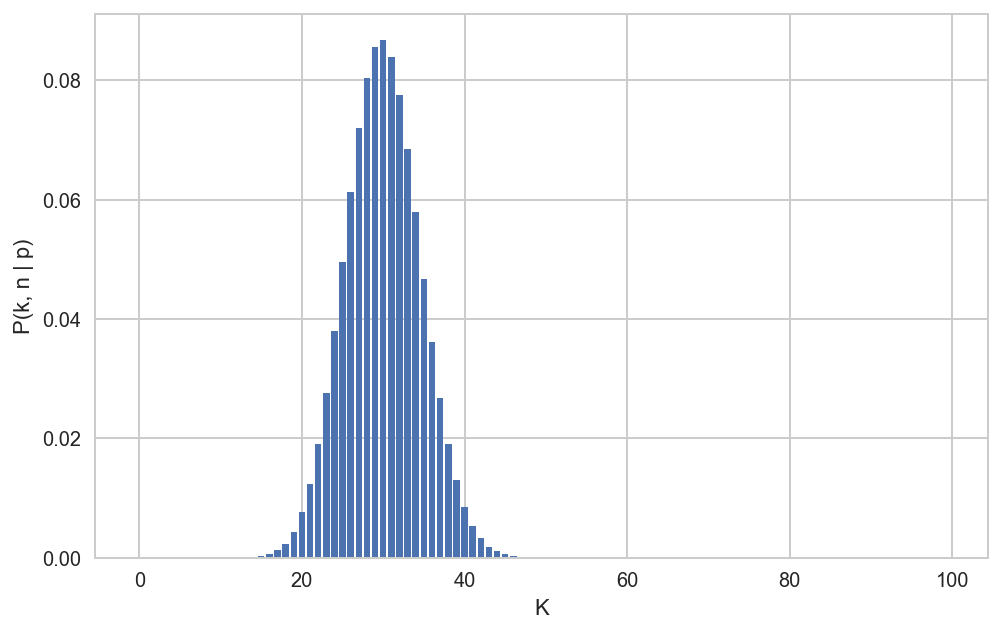

In [7]:
fig, ax = plt.subplots(figsize=(8,5))
kvals =  np.arange(0,100)
probs = binom.pmf(kvals)

ax.bar(kvals, probs)
ax.set_xlabel('K')
ax.set_ylabel('P(k, n | p)')
plt.show()





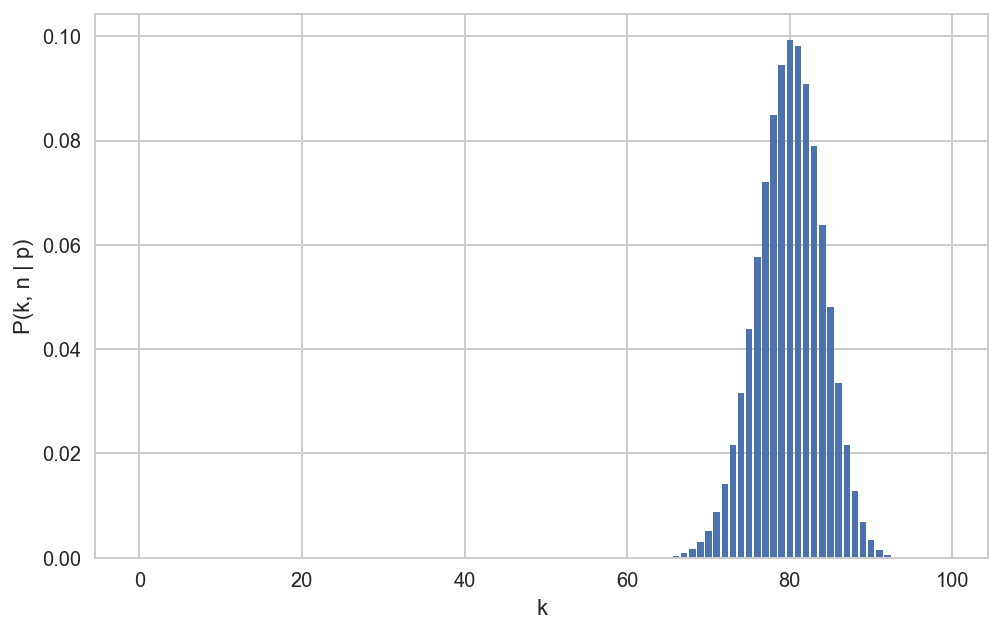

In [16]:
n = 100
p = 0.8

binom = stats.binom(n, p)

fig, ax = plt.subplots(figsize=(8,5))
kvals = np.arange(0,100)
probs = binom.pmf(kvals)

ax.bar(kvals, probs)
ax.set_xlabel('k')
ax.set_ylabel('P(k, n | p)')
plt.show()

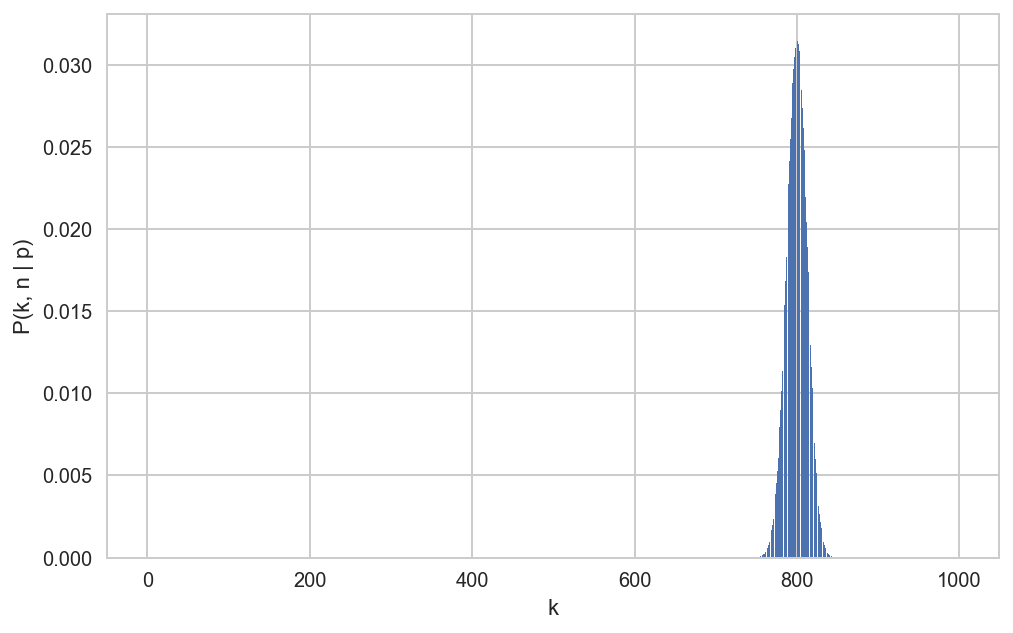

In [17]:
n = 1000
p = 0.8

binom = stats.binom(n, p)

fig, ax = plt.subplots(figsize=(8,5))
kvals = np.arange(0,1000)
probs = binom.pmf(kvals)

ax.bar(kvals, probs)
ax.set_xlabel('k')
ax.set_ylabel('P(k, n | p)')
plt.show()

<a id='p'></a>
## Modeling the parameter $p$ given counts of successes and failures
---

From here on let's say that we were measuring visitors to our site and also whether they chose to subscribe to our newsletter or not. So we redefine $n$, $k$, and $p$ accordingly:

### $$ \begin{aligned} n &= \text{number of visitors to our website} \\
k &= \text{number of visitors who subscribed} \\
p &= \text{probability of a visitor subscribing (unknown)} \end{aligned}$$

Remember, now we are _measuring_ $k$ subscribers out of the $n$ visitors. The measurement of subscribers can be considered our data.

At this point, we want to make an inference about the parameter $p$, our probability of a visitor subscribing. We can talk about this in terms of Bayes' Theorem:

### $$ P(p \;|\; data) = \frac{ P(data \;|\; p) }{ P(data) } P(p) $$

Or equivalently:

### $$ P(p \;|\; n,k) = \frac{ P(n,k \;|\; p) }{ P(n, k) } P(p) $$

Where we have:

### $$ \begin{aligned} 
P(p \;|\; n,k) &= \text{posterior} \\
P(n,k \;|\; p) &= \text{likelihood} \\
P(n,k) &= \text{marginal probability of the data} \\
P(p) &= \text{prior} 
\end{aligned} $$


In [18]:
n = 25 # number of visitors
p = 0.3
binom = stats.binom(n, p)

In [21]:
k =10  # how many ppl signed up
binom.pmf(k)

0.09163601238321302

In [23]:
p_frequ = k/n
p_frequ

0.4

<a id='likelihood'></a>
## The Binomial likelihood
---

Let's start with the likelihood. The likelihood represents the probability of observing $k$ successes out of $n$ trials _given a probability of success $p$._

This $p$ can be fixed, say at $p = 0.3$, in which case we would evaluate the likelihood at exactly that point. We could also represent $p$ as a distribution over the range of possible $p$ values. Like in the locomotive example, evaluating the likelihood at all of our different "hypotheses" about what $p$ could be. 

Let's start with a fixed value, $p = 0.3$. How do we evaluate the likelihood? As it turns out the likelihood function is the same as the probability mass function we wrote above, because this function is literally used to evaluate "what is the probability of $k$ successes given $n$ trials and $p$ probability of success". This is what we have formulated as the likelihood in the numerator.

**So we can use the binomial object initialized with $p = 0.3$ and $n = 25$ to find the likelihood value for a given $k$:**

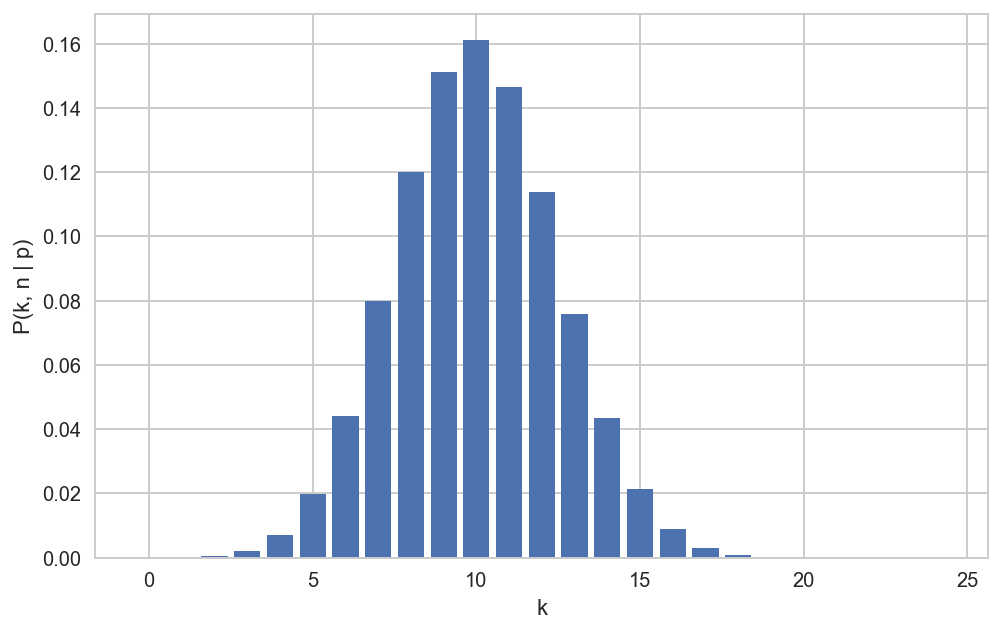

0.4


In [25]:
# A:
n = 25
k = 10
mle_p = k/n # this is the frequentist estimate for p

binom = stats.binom(n, mle_p)

fig, ax = plt.subplots(figsize=(8,5))
kvals = np.arange(0,25)
probs = binom.pmf(kvals)

ax.bar(kvals, probs)
ax.set_xlabel('k')
ax.set_ylabel('P(k, n | p)')
plt.show()

print(mle_p)

<a id='mle'></a>
## The "Maximum Likelihood Estimate" for $p$
---

If we were to _just_ focus on the likelihood part of Bayes Theorem, we could ask "what is the value of the parameter $p$ that maximizes the value of the likelihood function?" This is precisely what we do in Frequentist statistics to find our point estimate of a parameter. 

Remember that Frequentists have no interest in the prior or posterior beliefs about the probability of the parameter's value. Frequentists state that there is no probability associated with a parameter (such as our probability of subscription). There is one, _true_ probability of subscription if we were to measure the entire population. 

Because we only take a sample of people, we may by chance measure a probability of subscription that deviates from that true probability to some degree. Remember: in Frequentist statistics, it is the data that has a probability rather than the parameter!

**For the Binomial distribution, we can easily calculate the value for subscription rate $p$ that makes our observed data the most likely: it is going to be the fraction of successes that we measured in our data.**

In [5]:
# A:

<a id='likelihood-func'></a>
### The likelihood function (optional)

But we can also derive the MLE more formally. Our scenario is simple, but for distributions and models that are not so simple this becomes necessary.

**First, define the likelihood function $L$ (which is te same as the PMF):**

### $$ L(n, k \;|\; p) = \binom{n}{k} p^k (1 - p)^{(n-k)} $$

**Take the logarithm of this to get the log likelihood.**

### $$ LL(n, k \;|\; p) = ln\binom{n}{k} + k \cdot ln(p) + (n - k) \cdot ln(1 - p) $$


The log likelihood has nice properties. It allows the computer do do computations with very small probabilities multiplied together. It also gets rid of our exponents, which makes the derivative easier.

**Now take the derivative of the log likelihood with respect to $p$ and set this to 0.** This will find the value of $p$ that maximizes the log likelihood (the likelihood function is convex).

### $$ \begin{aligned}
\frac{\partial}{\partial p} LL(n, k \;|\; p) &= 0 \\
\frac{k}{p} - \frac{(n-k)}{(1-p)} &= 0 \\
\frac{(n-k)}{(1-p)} &= \frac{k}{p} \\
pn - pk &= k - pk \\
pn - pk + pk &= k \\
p &= \frac{k}{n} \\
\end{aligned}$$

**As you can see, this distills down to what we calculated before: the fraction of users that subscribed is the maximum likelihood estimate for the subscription rate.**

<a id='nonsense'></a>
### When the MLE does not make sense (non-optional!)

Now say instead we had $n = 5$ visitors to the site and to our surprise all of them subscribed, $k = 5$. Using the MLE for $p$ we would conclude that $p = 1.0$: a person has a %100 probability of subscribing when reaching our site.

Of course this is a very flawed conclusion. We have only measured 5 people! 

> **Note:** If we took the Frequentist route, we would ask "what is the probability that we measured this parameter $p = 1.0$ by chance when in fact the true rate is (some predetermined null hypothesis value) $H0_p = 0.3$?" This would be our p-value, a.k.a. alpha or Type I error, and with such insufficient data we would almost certainly fail to reject the null hypothesis.



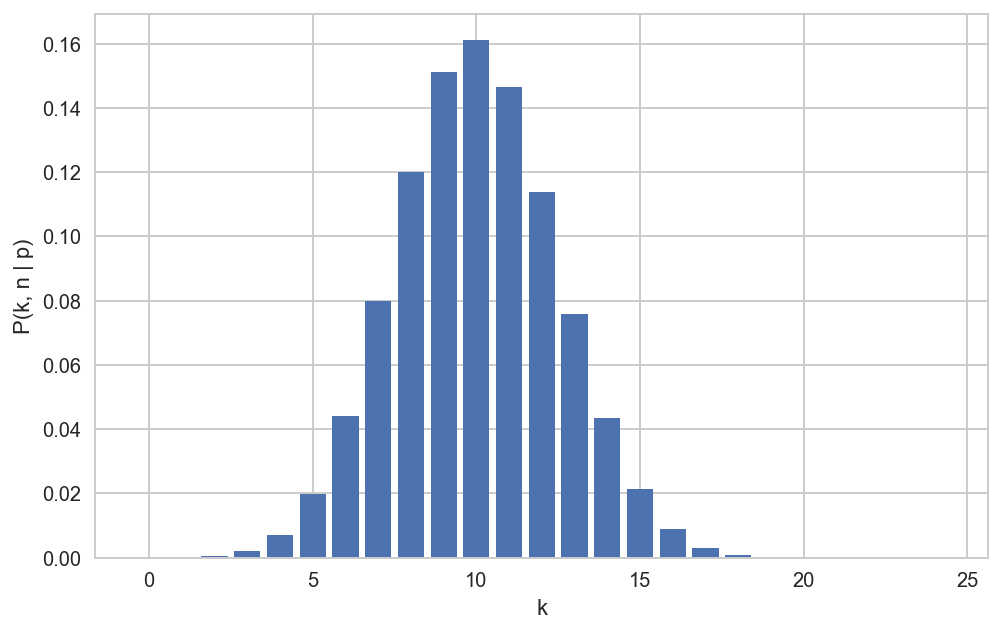

0.4


In [27]:
# A:
# A:
n = 25
k = 10
mle_p = k/n # this is the frequentist estimate for p

binom = stats.binom(n, mle_p)

fig, ax = plt.subplots(figsize=(8,5))
kvals = np.arange(0,25)
probs = binom.pmf(kvals)

ax.bar(kvals, probs)
ax.set_xlabel('k')
ax.set_ylabel('P(k, n | p)')
plt.show()

print(mle_p)

In [29]:
n = 5
k = 5
mle_p = 1.0

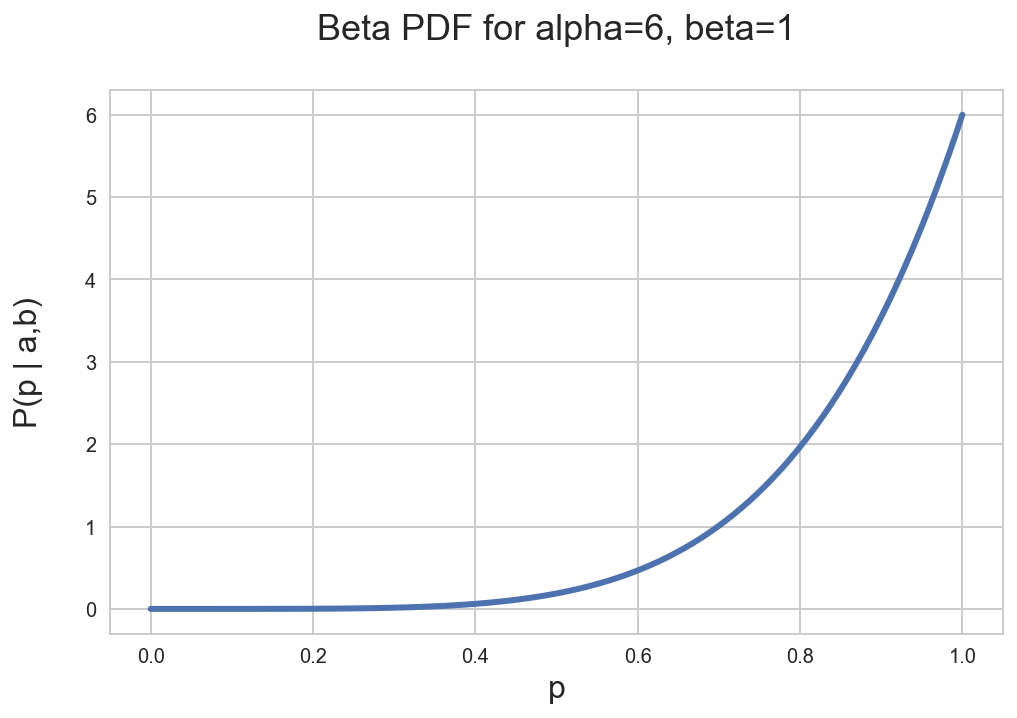

In [31]:
successes = 5
failures = 0
beta = stats.beta(successes+1, failures+1)

fig, ax = plt.subplots(figsize=(8, 5))
pvals = np.linspace(0.,1.,100)
like = beta.pdf(pvals)

ax.plot(pvals, like, lw=3)
ax.set_xlabel('p', fontsize=16)
ax.set_ylabel('P(p | a,b)\n', fontsize=16)
ax.set_title('Beta PDF for alpha=6, beta=1\n', fontsize=18)
plt.show()

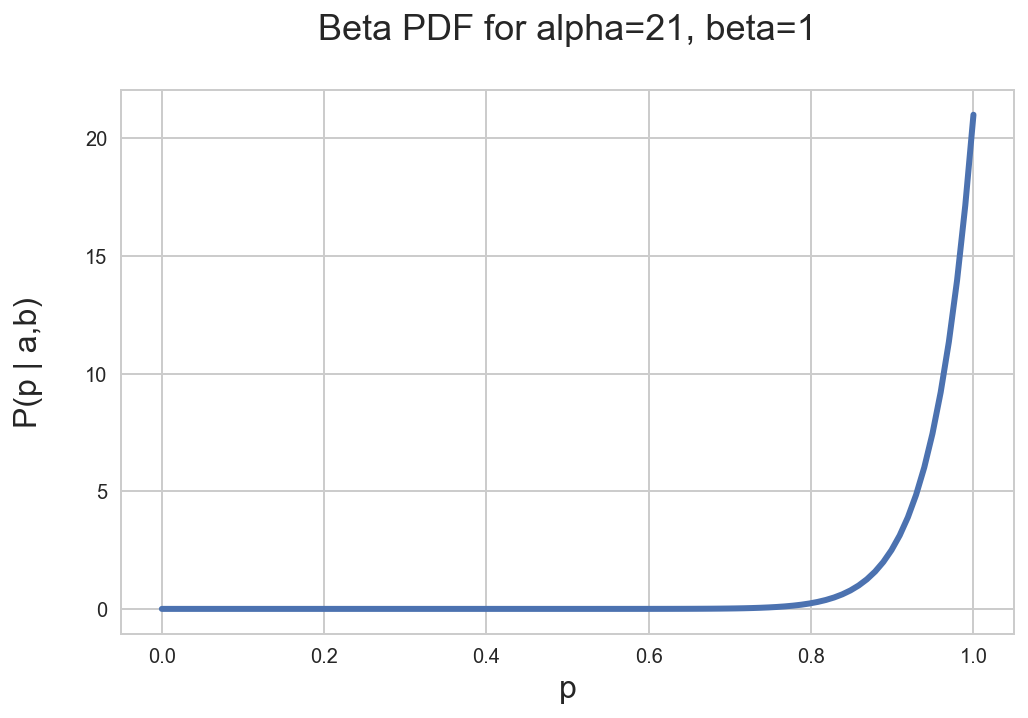

In [32]:
successes = 20
failures = 0
beta = stats.beta(successes+1, failures+1)

fig, ax = plt.subplots(figsize=(8, 5))
pvals = np.linspace(0.,1.,100)
like = beta.pdf(pvals)

ax.plot(pvals, like, lw=3)
ax.set_xlabel('p', fontsize=16)
ax.set_ylabel('P(p | a,b)\n', fontsize=16)
ax.set_title('Beta PDF for alpha=21, beta=1\n', fontsize=18)
plt.show()

<a id='beta'></a>

## Bayesian modeling of the parameter $p$ and the Beta distribution
---

What if we took a Bayesian rather than Frequentist approach?

Recall our model so far:

### $$ P(p \;|\; n,k) = \frac{ P(n,k \;|\; p) }{ P(n, k) } P(p) $$

Where we have:

### $$ \begin{aligned} 
P(p \;|\; n,k) &= \text{posterior} \\
P(n,k \;|\; p) &= \text{likelihood (Binomial distribution)} \\
P(p) &= \text{prior} 
\end{aligned} $$

Now, instead of thinking about the *data* as having a probability we think of the *parameter* $p$ as having a probability. In other words, different values of $p$ have different _likelihoods_. We will represent our beliefs about likely values of $p$ with our prior distribution.

**The distribution that represents _a distribution of probabilities_ is the Beta distribution. The beta distribution is parameterized by two values, $\alpha$ and $\beta$.**

###  $$ Beta(\alpha, \beta) =
\begin{cases}
\alpha &= \text{number of successes + 1} \\
\beta &= \text{number of failures + 1}
\end{cases} $$

**We can plot the beta distribution for the scenario where we measured $k = 5$ out of $n = 5$:**

In [7]:
# A:

**We can see from this distribution that our probability with the highest likelihood is 1.0. But, other probabilities are also likely!**  Due to our low sample size $n$, many values other than $p = 1.0$ have reasonable likelihood.

**What if we measured 20 subscriptions out of 20 visitors?** Plot this scenario below to see how the beta distribution changes.

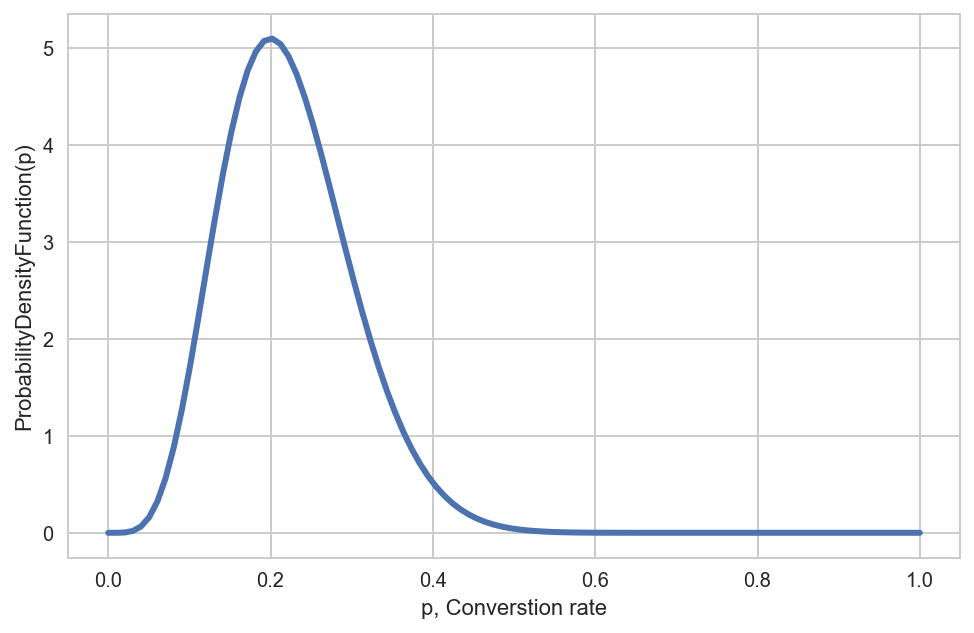

In [28]:
# A:n = 5
k = 5
alpha = k + 1
beta = n - k + 1

beta = stats.beta(alpha, beta)

fig, ax = plt.subplots(figsize=(8,5))
pvals = np.linspace(0, 1, 100)
prob_p = beta.pdf(pvals)

ax.plot(pvals, prob_p, lw=3)
ax.set_xlabel('p, Converstion rate')
ax.set_ylabel('ProbabilityDensityFunction(p)')

<a id='beta-pdf'></a>
## The Beta PDF and the Beta function
---

This is all well and good, but how is the Beta distribution defined? Formally, we define the probability density function of the beta distribution as:

### $$ PDF_{Beta}(x) = \frac{x^{\alpha-1}(1-x)^{\beta-1}}{\int_0^1 u^{\alpha-1} (1-u)^{\beta-1}\, du} $$

Where $x$ falls in the range [0, 1], and $u$ represents the values in that range to integrate over.

In the denominator, we are integrating over the possible probabilities. The denominator of the PDF is actually called the "Beta function", not to be confused with the Beta _distribution_. 

If this looks familiar to the equation for the binomial likelihood above, it's because it is. In the numerator we essentially have the binomial likelihood equation but with the "shape" parameters $\alpha$ and $\beta$ in place of our $k$ and $n$. In the denominator, we are integrating the binomial likelihood.


<a id='gamma'></a>
## The Gamma function (optional)
---

There is another way to write the Beta distribution, using something called the "Gamma function". 

The gamma function is defined as:

###  $$ \Gamma(z) =
\begin{cases}
(z - 1)! &= \text{when z is a positive integer} \\
\int_0^{\infty} x^{z-1} e^{-x} dx &= \text{when z is a complex or real number}
\end{cases} $$


<a id='beta-gamma'></a>
## Definining the Beta function using the Gamma function
---

The Gamma function is a generalization of the factorial function. The Beta _function_ can also be written in terms of the Gamma function:

### $$ Beta(\alpha, \beta) = \frac{ \Gamma (\alpha) \Gamma (\beta) }{\Gamma (\alpha + \beta) } = \int_0^1 u^{\alpha-1} (1-u)^{\beta-1}\, du $$

At this point, we can rewrite the Beta _distribution_, or probability density function, like so:

### $$ PDF_{Beta}(x) = \frac{\Gamma (\alpha + \beta) }{ \Gamma (\alpha) \Gamma (\beta) }x^{\alpha-1}(1-x)^{\beta-1} $$



<a id='beta-conjugate'></a>
## Putting it all together: the Beta as a "conjugate prior" to the Binomial likelihood
---

So remember - our beta distribution is what we are going to be using as our _prior_ over the probability of subscription $p$. In other words, we have some distribution of beliefs about which subscription rates are most likely as represented by a beta distribution.

**Recall now the setup of this problem in terms of Bayes formula:**

### $$ P(p \;|\; n,k) = \frac{ P(n,k \;|\; p) }{ P(k, n) } P(p) $$

Where we have:

### $$ \begin{aligned} 
P(p \;|\; n,k) &= \text{posterior} \\
P(n,k \;|\; p) &= \text{likelihood (Binomial distribution)} \\
P(p) &= \text{prior (Beta distribution)} 
\end{aligned} $$


**Let's ignore the normalizing constant, the marginal probability of the data $k,n$, for now. We can say then the unnormalized posterior is:**

### $$ P(p \;|\; n,k) \propto P(n,k \;|\; p) \cdot P(p) $$

**And we can put our Binomial likelihood and the Beta posterior in where we had the placeholders:**

### $$ P(p \;|\; n,k) \propto \binom{n}{k} p^k (1 - p)^{(n-k)} \cdot \frac{\Gamma (\alpha + \beta) }{ \Gamma (\alpha) \Gamma (\beta) }p^{\alpha-1}(1-p)^{\beta-1} $$

**Let's now define a constant $c$ as:**

### $$ c = \binom{n}{k} \cdot \frac{\Gamma (\alpha + \beta) }{ \Gamma (\alpha) \Gamma (\beta) } $$

**Now our formula for the unnormalized posterior is:**

### $$ \begin{aligned}
P(p \;|\; n,k) &\propto c \cdot p^k (1 - p)^{(n-k)} \cdot p^{\alpha-1}(1-p)^{\beta-1} \\
P(p \;|\; n,k) &\propto c \cdot p^{(k + \alpha - 1)} (1-p)^{(n - k + \beta - 1)}
\end{aligned}
$$

**And if we define a new alpha and beta:**

### $$ \begin{aligned}
\alpha_{posterior} &= k + \alpha_{prior} \\
\beta_{posterior} &= n - k + \beta_{prior}
\end{aligned} $$

**We can see that the posterior distribution can in fact be parameterized as a Beta distribution.** The constant term $c$ will be handled when we put the marginal likelihood back in and normalize the posterior distribution to be a proper probability distribution.

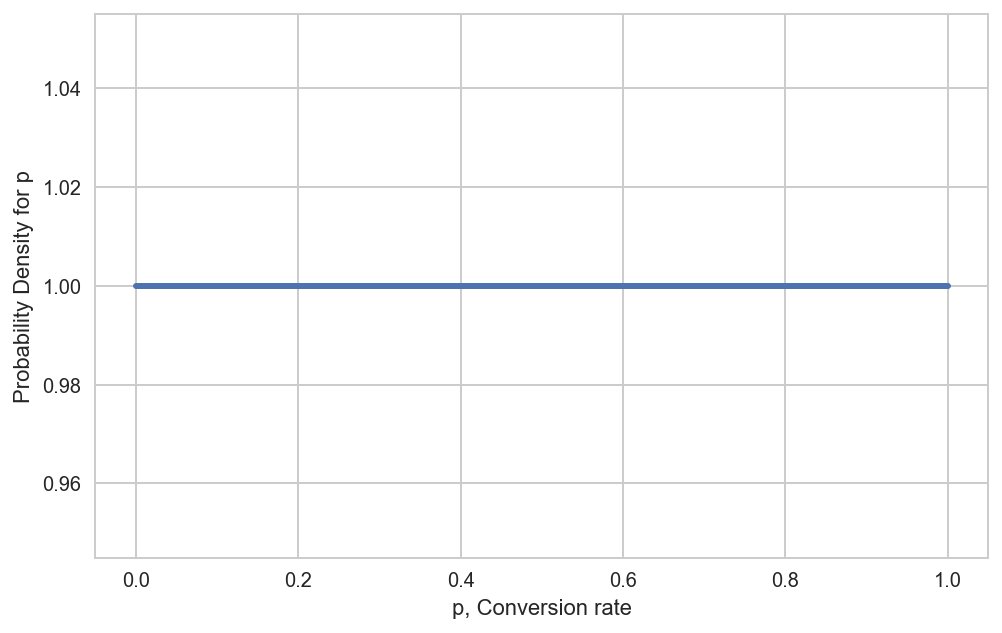

In [33]:
n_success = 0
n_failures = 0

# Prior: this is a Beta distribution
# Pick alpha, beta
alpha_prior = n_success + 1
beta_prior = n_failures + 1

beta_dist = stats.beta(alpha_prior, beta_prior)

fig, ax = plt.subplots(figsize=(8,5))
pvals = np.linspace(0, 1, 100)
prior = beta_dist.pdf(pvals)

ax.plot(pvals, prior, lw=3)
ax.set_xlabel('p, Conversion rate')
ax.set_ylabel('Probability Density for p')
plt.show()

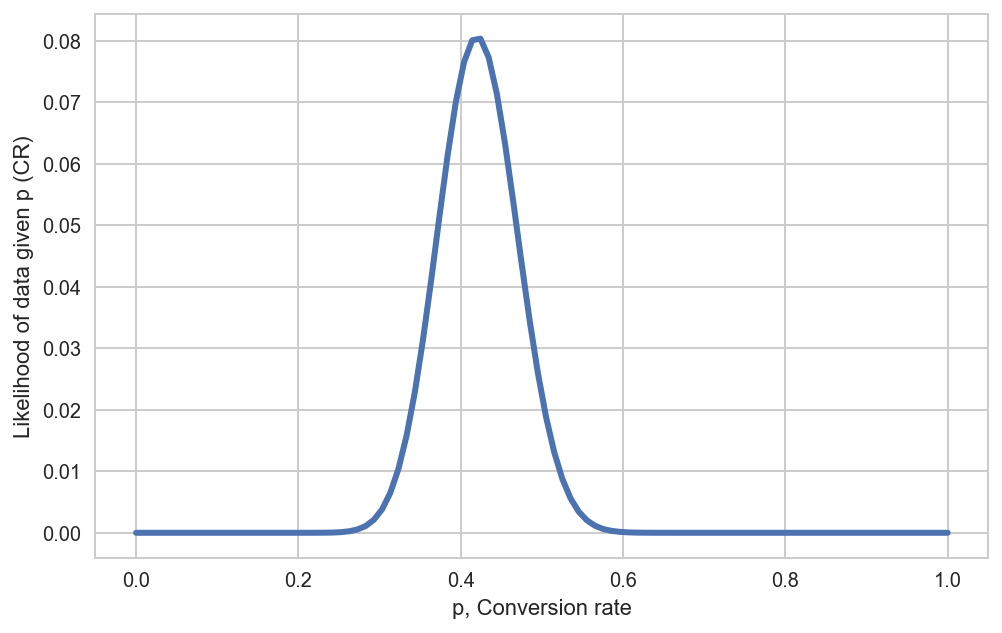

In [34]:
# Likelihood... binomial distribution, P(n,k | p)
# Need data here!!
n = 100
k = 42

likelihood = []
for p in pvals: # for each p value from my prior distribuion
    binom = stats.binom(n, p)
    likelihood.append(binom.pmf(k))
    
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(pvals, likelihood, lw=3)
ax.set_xlabel('p, Conversion rate')
ax.set_ylabel('Likelihood of data given p (CR)')
plt.show()

In [35]:
mle_p= k/n
mle_p

0.42

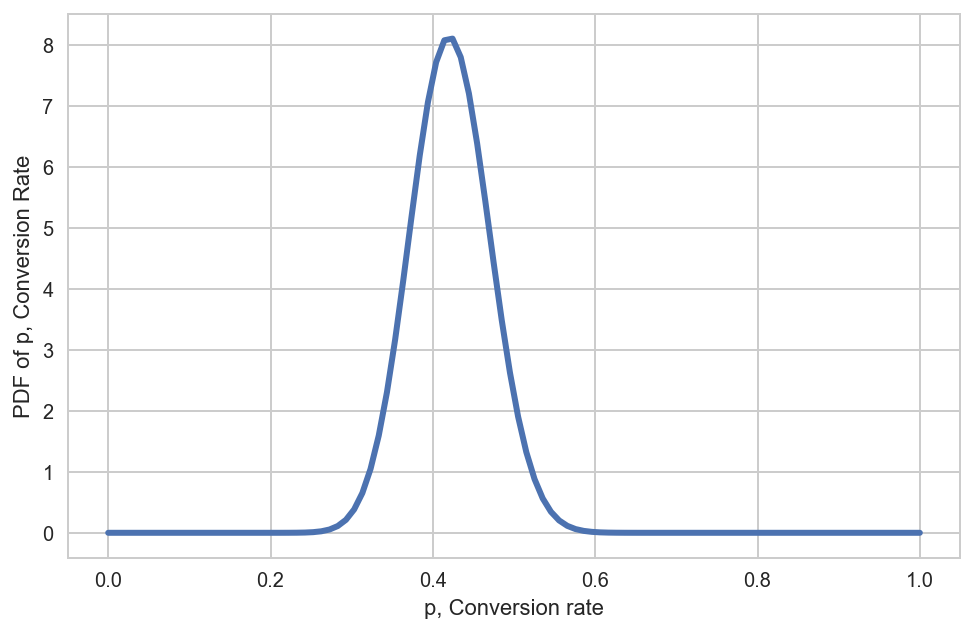

In [36]:
# Posterior

alpha_post = k + alpha_prior   # this is not universal
beta_post = n - k + beta_prior  # this works b/c i have beta-binomial
                                # model (i.e. conjugacy)
    
beta_dist = stats.beta(alpha_post, beta_post)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(pvals, beta_dist.pdf(pvals), lw=3)
ax.set_xlabel('p, Conversion rate')
ax.set_ylabel('PDF of p, Conversion Rate')
plt.show()

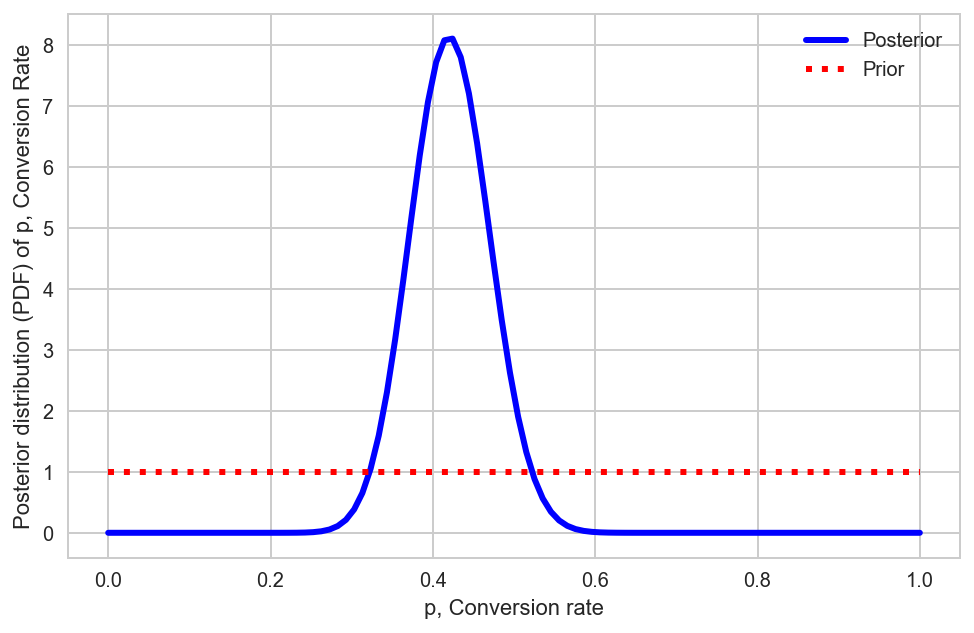

In [37]:
# Posterior

alpha_post = k + alpha_prior   # this is not universal
beta_post = n - k + beta_prior  # this works b/c i have beta-binomial
                                # model (i.e. conjugacy)
    
beta_dist = stats.beta(alpha_post, beta_post)

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(pvals, beta_dist.pdf(pvals), 'b', lw=3, label='Posterior')
ax.plot(pvals, prior, 'r:', lw=3, label='Prior')
ax.set_xlabel('p, Conversion rate')
ax.set_ylabel('Posterior distribution (PDF) of p, Conversion Rate')
ax.legend()
plt.show()

### MAP = Maximum A Posteriori = Mode of Posterior Distribution

Once we have $\alpha_{posterior}$ and $\beta_{posterior}$ for the Beta distribution, we have completely characterized the probability of the conversion rate.

The MAP (i.e., mode of the posterior distribution) can be calculated quite easily if the mathematical form of the distribution is known.  For Beta it is

### $$MAP(\alpha, \beta) = \frac{\alpha - 1}{\alpha + \beta - 2}$$

In [40]:
map_beta = (alpha_post - 1)/(alpha_post + beta_post - 2)
print(map_beta)

0.42
